In [776]:
# Core
import sys
import pandas as pd
import numpy as np
from pathlib import Path

## Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Harp/Bonsai
sys.path.append('../../src/')
from bonsai import load_bonsai_config
try:
    load_bonsai_config(r"C:\git\AllenNeuralDynamics\aind-vr-foraging\Bonsai")
except:
    load_bonsai_config(r"C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging\Bonsai")

import harp
import harp.processing
import data_io
import json 


C:\Users\tiffany.ona\AppData\Local\Temp\ipykernel_2176\1707455330.py:25: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


In [ ]:
session_df = pd.DataFrame(columns = ['session'])

In [ ]:
def compute_window(data, runningwindow,option, trial):
    """
    Computes a rolling average with a length of runningwindow samples.
    """
    performance = []
    end=False
    for i in range(len(data)):
        if data[trial].iloc[i] <= runningwindow:
            # Store the first index of that session
            if end == False:
                start=i
                end=True
            performance.append(round(np.mean(data[option].iloc[start:i + 1]), 2))
        else:
            end=False
            performance.append(round(np.mean(data[option].iloc[i - runningwindow:i]), 2))
    return performance

In [ ]:
#Global Viz settings
sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
# plt.rc('axes', titlesize=14)     # fontsize of the axes title
# plt.rc('axes', labelsize=13)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
# plt.rc('legend', fontsize=10)    # legend fontsize
# plt.rc('font', size=10)          # controls default text sizes

# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'Arial'

default_img_size = (12, 4)

### **Early way of processing the data**

In [ ]:
session_path = r"Z:\672107\20230921T112513\Behavior\Register__"

In [ ]:
path = r"Z:\672107\\20230921T112513"

# Open and read the JSON file
with open(str(path)+'\config.json', 'r') as json_file:
    config = json.load(json_file)
    
velocity_threshold = config['taskLogicControl']['positionControl']['stopResponseConfig']['velocityThreshold']

In [ ]:
water_on = harp.read_harp_bin(session_path+str(34)+".bin")
water_on = water_on.loc[water_on['Value'] & 0x08 > 0] * 0 + 1

odor1_on = harp.read_harp_bin(session_path+str(34)+".bin")
odor1_on = odor1_on.loc[odor1_on['Value'] & 16 > 0] * 0 + 1
odor1_off = harp.read_harp_bin(session_path+str(35)+".bin")
odor1_off = odor1_off.loc[odor1_off['Value'] & 16 > 0] * 0
odor1 = pd.concat([odor1_on, odor1_off], join='outer').sort_index()
odor1 = odor1.loc[odor1.Value.diff() != 0]

# Filter onsets of odor only. 
odor1 = odor1[odor1['Value'] == 1]
odor1['site_count'] = np.arange(odor1.shape[0])

#Remove the trials in which I gave the animal manual water but discarding rapid succession of onsets
water_on['filter'] = water_on.index.diff()
water_on = water_on.loc[water_on['filter'] >= 2]

In [ ]:
odor1['stopped'] = 0
odor1['stopped_time'] = np.nan
# Create a column for the number of patched the animal has experienced. 
temp_stopped = water_on
for row in odor1.itertuples():
    if temp_stopped.shape[0] == 0:
        break
    if row.Index+8 > temp_stopped.index[0]:
        odor1.loc[row.Index, "stopped"] = temp_stopped['Value'].iloc[0]
        odor1.loc[row.Index, "stopped_time"] = temp_stopped.index[0]
        temp_stopped = temp_stopped.iloc[1:]


In [ ]:
data = odor1
window_size = 10
odor1['stopped_average'] = compute_window(data, window_size, 'stopped', 'site_count')

In [ ]:
# Remove the last % of the session
maximum_sites = odor1.shape[0]*0.8
odor1 = odor1.iloc[:int(round(maximum_sites,0))]

In [ ]:
# Create a figure and primary (left) axis
fig, ax1 = plt.subplots(figsize=(8, 3))
sns.lineplot(x='site_count', y='stopped_average', data=odor1, color='black', ax=ax1)

# Create a secondary (right) axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot data on the secondary axis
ax2.hlines(y=velocity_threshold, xmin=0, xmax=odor1.shape[0], color='red', linestyles='dashed')

plt.xlabel('Reward site')

ax1.set_ylabel('(P|Stop)')
ax2.set_ylabel('Velocity threshold (cm/s)')

ax1.set_ylim(0,1)
sns.despine()

In [ ]:
# plt.figure(figsize=(8,3))
# sns.lineplot(x=odor1.index - odor1.index[0], y='site_count', data=odor1, color='black')
# plt.xlabel('Time (s)')
# plt.ylabel('Travelled Sites')
# sns.despine()

In [ ]:
odor1.loc[:, 'session'] = len(session_df.session.unique()) + 1
odor1.loc[:,'session_id'] = session_path[10:25]
odor1.loc[:,'animal_id'] = session_path[3:9]

session_df = pd.concat([session_df, odor1], ignore_index=True)

In [ ]:
session_df.tail()

### **Sessions with intermediate code** 
After the 19th of September

In [ ]:
path = r"Z:\672107\20230921T112513"
# session_path = Path(r"Z:\672107\20231010T120003")
session_path = Path(path)


# Harp Devices:
HarpBehavior = harp.HarpDevice("Behavior")
AnalogInput = harp.HarpDevice("AnalogInput")
harp_behavior_data = data_io.HarpSource(device=HarpBehavior, path=session_path / "Behavior", name="behavior", autoload=False)

# Software Events
software_events = data_io.SoftwareEventSource(path=session_path / "SoftwareEvents", name="software_events")
active_site = software_events.streams.ActiveSite.data
active_patch = software_events.streams.ActivePatch.data
# active_patch = software_events.streams.OdorControl.data
stopped = software_events.streams.ChoiceFeedback.data


In [ ]:
# Open and read the JSON file
with open(str(session_path)+'\config.json', 'r') as json_file:
    config = json.load(json_file)
    
velocity_threshold = config['taskLogicControl']['positionControl']['stopResponseConfig']['velocityThreshold']

In [ ]:
# Odor onsets
## mask for digital outputs
digital_outputs = HarpBehavior.module.DigitalOutputs

## Load necessary files
harp_behavior_data.streams.OutputSet.load_from_file()
harp_behavior_data.streams.OutputClear.load_from_file()
odor_0 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort1)
odor_1 = harp.processing.distinct_until_changed_state(harp_behavior_data.streams.OutputSet.data, harp_behavior_data.streams.OutputClear.data, digital_outputs.SupplyPort2)

water_state = harp_behavior_data.streams.OutputSet.data.loc[harp_behavior_data.streams.OutputSet.data["Value"] == digital_outputs.SupplyPort0]

In [ ]:
active_site = active_site.drop(['timestampSource', 'index'], axis=1)

# Use json_normalize to create a new DataFrame from the 'data' column
df_normalized = pd.json_normalize(active_site['data'])
df_normalized.index = active_site.index

# Concatenate the normalized DataFrame with the original DataFrame
active_site = pd.concat([active_site, df_normalized], axis=1)

# Drop the original 'data' column if you want to remove it
active_site = active_site.drop('data', axis=1)

active_site = active_site[['label', 'startPosition','length']]

In [ ]:
# Filter reward sites only
reward_sites = active_site[active_site['label'] == 'Reward']
reward_sites.loc[:,'site_count'] = np.arange(reward_sites.shape[0])

In [ ]:
odors_onset = pd.concat(
    [
        odor_0[odor_0["Value"]].assign(Value=0),
        odor_1[odor_1["Value"]].assign(Value=1),
    ], axis=0, copy=True).sort_index()

## For each reward, get the first odor onset
reward_sites["odor_onset"] = np.nan
reward_sites["odor"] = np.nan

for site in reward_sites.itertuples():
    arg_min, val_min = harp.processing.find_closest(site.Index, odors_onset.index, mode="closest")

    reward_sites.loc[site.Index, "odor_onset"] = val_min
    reward_sites.loc[site.Index, "odor"] = odors_onset["Value"].iloc[arg_min]        

In [ ]:
reward_sites.loc[:,'stopped'] = 0
# Create a column for the number of patched the animal has experienced. 
temp_stopped = stopped.copy()
for row in reward_sites.itertuples():
    if temp_stopped.shape[0] == 0:
        break
    if row.odor_onset+5 > temp_stopped.index[0]:
        reward_sites.loc[row.Index, "stopped"] = temp_stopped['timestampSource'].iloc[0]
        reward_sites.loc[row.Index, "stopped_time"] = temp_stopped.index[0]
        temp_stopped = temp_stopped.iloc[1:]

In [ ]:
window_size = 10

reward_sites.loc[:,'stopped_average'] = compute_window(reward_sites, window_size, 'stopped', 'site_count')
reward_sites.loc[:,'session'] = len(session_df.session.unique()) + 1
reward_sites.loc[:,'threshold'] = velocity_threshold

In [ ]:
# Remove the last % of the session
maximum_sites = reward_sites.shape[0]*0.8
reward_sites = reward_sites.iloc[:int(round(maximum_sites,0))]

In [ ]:
# Create a figure and primary (left) axis
fig, ax1 = plt.subplots(figsize=(8, 3))
sns.lineplot(x='site_count', y='stopped_average', data=reward_sites, color='black', ax=ax1)

# Create a secondary (right) axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot data on the secondary axis
ax2.hlines(y=velocity_threshold, xmin=0, xmax=reward_sites.shape[0], color='red', linestyles='dashed')

plt.xlabel('Reward site')

ax1.set_ylabel('(P|Stop)')
ax2.set_ylabel('Velocity threshold (cm/s)')

ax1.set_ylim(0,1)
sns.despine()

In [ ]:
reward_sites.loc[:, 'session'] = len(session_df.session.unique()) + 1
reward_sites.loc[:,'session_id'] = path[10:25]
reward_sites.loc[:,'animal_id'] = path[3:9]

session_df = pd.concat([session_df, reward_sites[['site_count', 'stopped', 'stopped_time', 'stopped_average', 'session', 'session_id','animal_id']]], ignore_index=True)

In [ ]:
session_df.tail(5)

In [ ]:
session_df['total_sites'] = np.arange(len(session_df))

In [ ]:
# Create a figure and primary (left) axis
fig, ax1 = plt.subplots(figsize=(8, 3))
sns.lineplot(x='total_sites', y='stopped_average', hue='session', data=session_df, color='black', ax=ax1)

plt.xlabel('Reward site')

ax1.set_ylabel('(P|Stop)')
ax1.set_ylim(0,1)
sns.despine()

In [ ]:
session_df.to_csv('C:/Users/tiffany.ona/OneDrive - Allen Institute/Documents/VR foraging/Data/session_df_107.csv')

### **Plot all sessions  together**

In [672]:
session_df = pd.DataFrame()
for animal in ['103','104','106','107']:
    session = pd.read_csv('C:/Users/tiffany.ona/OneDrive - Allen Institute/Documents/VR foraging/Data/session_df_'+animal+'.csv', index_col=0)
    session_df = pd.concat([session_df, session], ignore_index=True)

In [682]:
session_df.head(5)

,session,Value,site_count,stopped,stopped_time,stopped_average,session_id,animal_id,total_sites
10,1.0,1.0,10.0,1.0,16321.957504,0.64,20230918T142413,672103,10
11,1.0,1.0,11.0,1.0,16373.610496,0.70,20230918T142413,672103,11
12,1.0,1.0,12.0,1.0,16422.288480,0.80,20230918T142413,672103,12
13,1.0,1.0,13.0,1.0,16433.706496,0.90,20230918T142413,672103,13
14,1.0,1.0,14.0,0.0,NaN,0.90,20230918T142413,672103,14


In [680]:
# Remove the first 10 sites
session_df = session_df.loc[session_df['site_count'] >= 10]

c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c

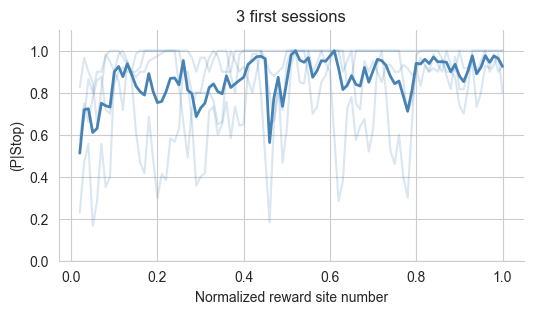

In [782]:
session_df['normalized_trials'] = 0.0
for animal in session_df.animal_id.unique():
    session_df.loc[session_df['animal_id'] == animal, 'normalized_trials'] =   (session_df.loc[session_df['animal_id'] == animal, 'total_sites']
                                                                                / session_df.loc[session_df['animal_id'] == animal, 'total_sites'].max())

session_df['round_normalized_trials'] = session_df['normalized_trials'].round(2)
session_df = session_df.replace([np.inf, -np.inf], np.nan)

# Create a figure and primary (left) axis
black_palette = ["steelblue"] * len(session_df["animal_id"].unique())

fig = plt.subplots(figsize=(6, 3))
sns.lineplot(x='round_normalized_trials', y='stopped_average', hue='animal_id', palette=black_palette, data=session_df, alpha=0.2, legend=False, errorbar=None)
sns.lineplot(x='round_normalized_trials', y='stopped_average', data=session_df, color='steelblue', errorbar=None, linewidth=2)

plt.xlabel('Normalized reward site number')
plt.ylabel('(P|Stop)')
plt.ylim(0,1.1)
plt.title('3 first sessions')
sns.despine()

c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c

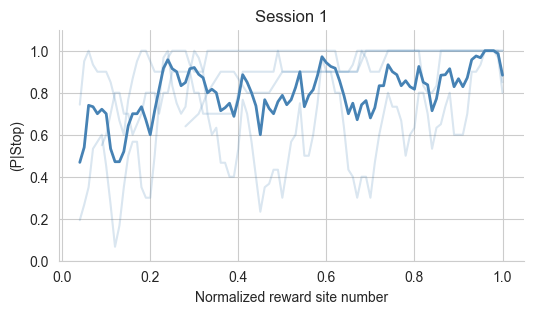

In [781]:
df_temp = session_df.loc[session_df['session'] == 1]

df_temp.loc[:, 'normalized_trials'] = 0.0
for animal in df_temp.animal_id.unique():
    df_temp.loc[df_temp['animal_id'] == animal, 'normalized_trials'] =   (df_temp.loc[df_temp['animal_id'] == animal, 'total_sites']
                                                                                / df_temp.loc[df_temp['animal_id'] == animal, 'total_sites'].max())

df_temp.loc[:,'round_normalized_trials'] = df_temp.loc[:,'normalized_trials'].round(2)

session_df['normalized_trials'] = 0.0
for animal in session_df.animal_id.unique():
    session_df.loc[session_df['animal_id'] == animal, 'normalized_trials'] =   (session_df.loc[session_df['animal_id'] == animal, 'total_sites']
                                                                                / session_df.loc[session_df['animal_id'] == animal, 'total_sites'].max())

session_df['round_normalized_trials'] = session_df['normalized_trials'].round(2)

# Create a figure and primary (left) axis
black_palette = ["steelblue"] * len(session_df["animal_id"].unique())

fig = plt.subplots(figsize=(6, 3))
sns.lineplot(x='round_normalized_trials', y='stopped_average', hue='animal_id', palette=black_palette, data=df_temp, alpha=0.2, legend=False, errorbar=None)
sns.lineplot(x='round_normalized_trials', y='stopped_average', data=df_temp, color='steelblue', errorbar=None, linewidth=2)

plt.xlabel('Normalized reward site number')
plt.ylabel('(P|Stop)')
plt.title('Session 1')
plt.ylim(0,1.1)
sns.despine()

c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c

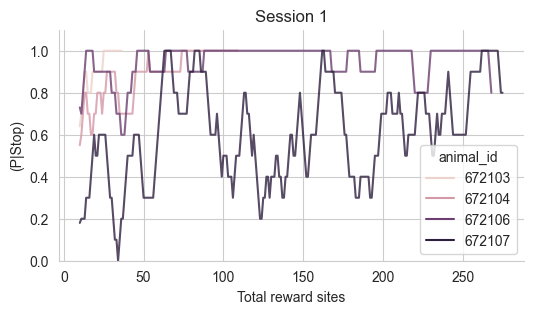

In [784]:
df_temp = session_df.loc[session_df['session'] == 1]

df_temp.loc[:, 'normalized_trials'] = 0.0
for animal in df_temp.animal_id.unique():
    df_temp.loc[df_temp['animal_id'] == animal, 'normalized_trials'] =   (df_temp.loc[df_temp['animal_id'] == animal, 'total_sites']
                                                                                / df_temp.loc[df_temp['animal_id'] == animal, 'total_sites'].max())

df_temp.loc[:,'round_normalized_trials'] = df_temp.loc[:,'normalized_trials'].round(2)

session_df['normalized_trials'] = 0.0
for animal in session_df.animal_id.unique():
    session_df.loc[session_df['animal_id'] == animal, 'normalized_trials'] =   (session_df.loc[session_df['animal_id'] == animal, 'total_sites']
                                                                                / session_df.loc[session_df['animal_id'] == animal, 'total_sites'].max())

session_df['round_normalized_trials'] = session_df['normalized_trials'].round(2)

# Create a figure and primary (left) axis
# black_palette = ["steelblue"] * len(session_df["animal_id"].unique())

sns.set_palette("colorblind")
fig = plt.subplots(figsize=(6, 3))
sns.lineplot(x='total_sites', y='stopped_average', hue='animal_id', data=df_temp, alpha=0.8, errorbar=None)
# sns.lineplot(x='total_sites', y='stopped_average', data=df_temp, color='steelblue', errorbar=None, linewidth=2)

plt.xlabel('Total reward sites')
plt.ylabel('(P|Stop)')
plt.title('Session 1')
plt.ylim(0,1.1)
sns.despine()

c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\aind-vr-foraging-analysis\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c

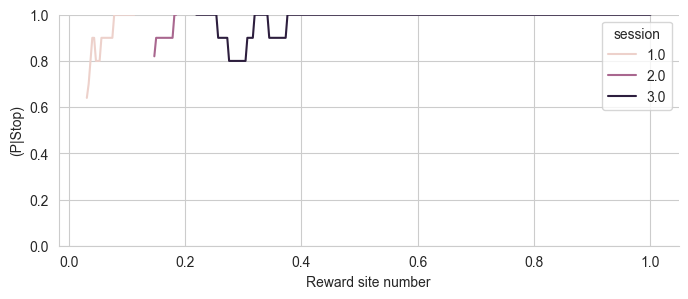

In [719]:
# Create a figure and primary (left) axis
black_palette = ["black"] * len(session_df["animal_id"].unique())

fig = plt.subplots(figsize=(8, 3))
sns.lineplot(x='normalized_trials', y='stopped_average', hue='session', data=session_df.loc[session_df['animal_id'] == 672103])

plt.xlabel('Reward site number')
plt.ylabel('(P|Stop)')
plt.ylim(0,1)
sns.despine()